Cp: [0.22338, 0.09868, 0.18135, 0.12179, 0.13019, 0.11409, 0.10965, 0.11156, 0.09933, 0.08699, 0.08575, 0.07659, 0.07052, 0.06548, 0.06047, 0.05378, 0.04653, 0.03956, 0.03357, 0.02612, 0.01876, 0.01229, 0.00209, -0.00956, -0.02131, -0.03069, -0.03966, -0.0515, -0.06252, -0.07393, -0.08428, -0.0964, -0.10902, -0.11985, -0.13192, -0.14529, -0.1588, -0.16919, -0.18315, -0.19763, -0.20849, -0.2196, -0.23428, -0.24459, -0.25521, -0.26953, -0.28188, -0.28867, -0.30371, -0.31602, -0.31907, -0.33166, -0.34897, -0.33873, -0.35939, -0.3832, -0.36826, -0.35471, -0.35862, -0.38302, -0.40274, -0.38791, -0.36959, -0.38876, -0.38529, -0.37286, -0.37226, -0.37648, -0.37005, -0.36332, -0.36284, -0.36247, -0.35655, -0.34933, -0.348, -0.34379, -0.33601, -0.32464, -0.31557, -0.32051, -0.31643, -0.30436, -0.29276, -0.28519, -0.27793, -0.26182, -0.24059, -0.22677, -0.20223, -0.18469, -0.16831, -0.14844, -0.11974, -0.06108, -0.00645, -0.01626, 0.6039, 0.86267, 0.97715, 0.99224, 0.95041, 0.85168, 0.64824, 0.2

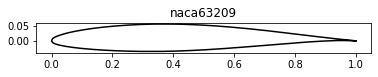

In [9]:
## This code is developed by Sreemannarayana Ikkurthi
## As a part of course notes for the course 15AES302: Aerodynamics II in the year 2019-20
## In support of Dr. Rajesh Senthil Kumar T., Assistant Professor 
## Department of Aerospace Engneering, Amrita Vishwa Vidyapeetham

#################################### All the libraries imported are below #################################################
import subprocess as sp
import random
import os
import math
import numpy
import matplotlib.pyplot as plt
from scipy import interpolate
import shutil
###########################################################################################################################

###################################### Defined functions below this #######################################################
class xfoil():
        
    def open_xfoil(self):
        ps = sp.Popen(xfoil_path + r'xfoil.exe', stdin = sp.PIPE)
        self.ps = ps

    def write_xfoil(self, inp):
        inp = bytes(inp, 'utf-8')
        self.ps.stdin.write(inp + b'\n')

    def close_xfoil(self):
        self.ps.stdin.close()
        self.ps.wait()

    # To get airfoil coordinates from xfoil. This can generate NACA 4 or 5 digit series airfoils. 
    # air_code is the input variable which is NACA 4 or 5 digit code.
    # Saves the coordinates as .txt file.
    def get_airfoil(self, air_code):
        self.open_xfoil()
        self.write_xfoil(f'NACA {air_code}')
        self.write_xfoil('SAVE')
        self.write_xfoil(f'NACA {air_code} .txt')
        self.close_xfoil()
        (x, y) = extract.coordinates(f'NACA {air_code} .txt')
        return x, y

    def load_foil(self, file_name):
        self.open_xfoil()
        self.write_xfoil(f'LOAD')
        self.write_xfoil(f'{file_name}.dat')
        self.write_xfoil(f'{file_name}')

    def ini_oper(self, file_name, Re, Mach, N_crit):
        self.load_foil(file_name)
        self.write_xfoil(f'PCOP')
        self.write_xfoil(f'OPER')
        self.write_xfoil(f'Re')
        self.write_xfoil(f'{Re}')
        self.write_xfoil(f'Mach')
        self.write_xfoil(f'{Mach}')
        self.write_xfoil(f'VPAR')
        self.write_xfoil(f'N')
        self.write_xfoil(f'{N_crit}')
        self.write_xfoil(f'')

    # Saves the output of cp after operating on airfoil with given input
    def cp_oper(self, file_name, Re, Mach, N_crit, Alpha):
        self.ini_oper(file_name, Re, Mach, N_crit)
        self.write_xfoil(f'ALFA')
        self.write_xfoil(f'{Alpha}')
        self.write_xfoil(f'CPWR')
        self.write_xfoil(f'Cp_{file_name}_({Alpha}).txt')
        self.close_xfoil()
        copy_item(code_path, results_path, r'Cp_' + file_name + r'_(' + str(Alpha) + r')' + r'.txt')
        cp = extract.cp(r'Cp_' + file_name + r'_(' + str(Alpha) + r')' + r'.txt')
        os.remove(r'Cp_' + file_name + r'_(' + str(Alpha) + r')' + r'.txt')
        return cp
    
    # Saves the output of polars after operating on airfoil with given input 
    def polar_oper(self, file_name, Re, Mach, N_crit, Alpha):
        self.ini_oper(file_name, Re, Mach, N_crit)
        self.write_xfoil(f'PACC')
        self.write_xfoil(f'Polar_{file_name}.txt')
        self.write_xfoil(f'')
        self.write_xfoil(f'ALFA')
        self.write_xfoil(f'{Alpha}') 
        self.close_xfoil()
        copy_item(code_path, results_path, r'Polar_' + file_name + r'.txt')
        (alpha, cl, cd, cdp, cm) = extract.polar(r'Polar_' + file_name + r'.txt')
        os.remove(r'Polar_' + file_name + r'.txt')
        return alpha, cl, cd, cdp, cm

class extract():
    # Removes unnecessary strings in a file
    def remove_str(self, name):
        f=open(name, 'r+', errors='ignore')
        s=f.readlines()
        stror=len(s)
        n=len(s)
        count=0
        i=0
        while (count<n):
            coun=0
            for j in range(len(s[i])):
                if(ord(s[i][j])>58):
                    s.remove(s[i])
                    coun=1
                if coun==1:
                    break
            a1=len(s)
            if(stror==a1):
                i=i+1
            stror=a1
            count=count+1
        f.truncate(0)
        f.seek(0)
        f.writelines(s)
        f.close()
    
    # Extracts the airfoil coordinates from .dat file
    def coordinates(self, foil):
        remove_str(foil)
        with open(foil, 'r+', errors='ignore') as infile: 
            dummy_x, dummy_y = numpy.loadtxt(infile, unpack=True, skiprows=0)
            x = dummy_x.tolist()
            y = dummy_y.tolist()
        if x[0] > 1:
            x = x[1:]
            y = y[1:]
        return x, y

    # Extracts the cp from the output file
    def cp(self, foil):
        remove_str(foil)
        with open(foil, 'r+', errors='ignore') as infile: 
            dummy = numpy.genfromtxt(infile, delimiter=[10,9,9], dtype=None).tolist()
            cp = [x[2] for x in dummy]
        return cp
    
    def polar(self, foil):
        remove_str(foil)
        with open(foil, 'r+', errors='ignore') as infile: 
            dummy = numpy.genfromtxt(infile, delimiter=[9,9,9,10,9], dtype=float).tolist()
            alpha = [x[0] for x in dummy]
            cl = [x[1] for x in dummy]
            cd = [x[2] for x in dummy]
            cdp = [x[3] for x in dummy]
            cm = [x[4] for x in dummy]
        alpha = alpha[6:]
        cl = cl[6:]
        cd = cd[6:]
        cdp = cdp[6:]
        cm = cm[6:]
        return alpha, cl, cd, cdp, cm

# Create any number of random digit numbers.
# Input varaiables are n_digits and n_airfoils, n_digits is the number of digits of airfoil code.
# n_airfoils is the number of airfoil codes to be generated.
# It returns a list of airfoil codes.
def rand_digit(n_digits, n_airfoils):
    air_code = []
    for j in range(n_airfoils):
        code = ''
        for i in range(n_digits):
            code += str(random.randint(0, 9))
        air_code.append(code)
    return air_code

#seperate top and bottom half of airfoil.
#x is the x-coordinates of airfoil and y is the y-coordinates of airfoil.
#Returns xu, yu, xl, yl. 
#xu is upper x-coordinates, yu is upper y-coordinates, xl is lower x-coordinates, yl is lower y-coordinates
def seperate_airfoil(x, y):
    count = 0
    for i in range(len(x)-1):
        if x[count + 1] > x[count]:
            count += 1
        else:
            count = 0

    if (count + 1) < len(x):
        if x[0] > x[1]: 
            xu = [x[0]]
            yu = [y[0]]
            xl = []
            yl = []
            for i in range(len(x) - 1):
                if x[i + 1] < x[i]:
                    xu.append(x[i + 1]) 
                    yu.append(y[i + 1])
                else:
                    break
            while i < (len(x) - 1):       
                xl.append(x[i + 1])
                yl.append(y[i + 1])
                i += 1
            yl = [yl for xl, yl in sorted(zip(xl, yl))]
            xl = sorted(xl)
            if (xu[-1] != xl[0]) and (xl[0] != xl[1]):
                xl.insert(0, xu[-1])
                yl.insert(0, yu[-1])
            if xl[0] == xl[1]:
                xl.remove(xl[0])
                yl.remove(yl[0])
            return xu, yu, xl, yl
        else:
            xu = [x[0]]
            yu = [y[0]]
            xl = []
            yl = []
            for i in range(len(x) - 1):
                if x[i + 1] > x[i]:
                    xu.append(x[i + 1]) 
                    yu.append(y[i + 1])
                else:
                    break
            while i < (len(x) - 1):        
                xl.append(x[i + 1])
                yl.append(y[i + 1])
                i += 1
            yl = [yl for xl, yl in sorted(zip(xl, yl))]
            xl = sorted(xl)
            if (xu[0] != xl[0]) and (xl[0] != xl[1]):
                xl.insert(0, xu[0])
                yl.insert(0, yu[0])
            if xl[0] == xl[1]:
                xl.remove(xl[0])
                yl.remove(yl[0])
            if xu[0] < xu[1]:
                xu = list(reversed(xu))
                yu = list(reversed(yu))
            return xu, yu, xl, yl
    else:
        xu = list(reversed(x))
        yu = list(reversed(y))
        xl = x[:]
        yl = y[:]
        return xu, yu, xl, yl

# Obtain extra points by interrpolating spline for given airfoil data from xu, yu, xl, yl.
# Inputs are xu, yu, xl, yl and pts. pts is the number of points required on each half of airfoil (upper and lower).
# Returns new coordinates. new_xu, new_yu, new_xl, new_yl.
def xtra_pts(x, y, pts):
    (xu, yu, xl, yl) = seperate_airfoil(x, y)
    
    yu_sorted = [yu for xu, yu in sorted(zip(xu, yu))]

    yl_sorted = [yl for xl, yl in sorted(zip(xl, yl))]
    
    sp_u = interpolate.PchipInterpolator(sorted(xu), yu_sorted, extrapolate = False)
    sp_l = interpolate.PchipInterpolator(sorted(xl), yl_sorted, extrapolate = False)
    
    theta_u = numpy.linspace(math.pi, 2*math.pi, num = pts, endpoint = True)
    theta_u = theta_u.tolist()
    theta_l = numpy.linspace(0, math.pi, num = pts, endpoint = True)
    theta_l = theta_l.tolist()
    
    new_xu = []
    new_xl = []
    for i in range(len(theta_u)):
        new_xu.append(xu[-1] + (1-(math.cos(theta_u[i])))*((abs(xu[-1]-xu[0]))/2))
    for i in range(len(theta_l)):
        new_xl.append(xl[0] + (1-(math.cos(theta_l[i])))*((abs(xl[-1]-xl[0]))/2))

    new_yu = sp_u(new_xu)
    new_yu = new_yu.tolist()

    new_yl = sp_l(new_xl)
    new_yl = new_yl.tolist()

    if new_xu[-1] == new_xl[0]:
        new_xl = new_xl[1:]
        new_yl = new_yl[1:]
    
    return new_xu, new_yu, new_xl, new_yl

# Saves the coordines x, y into a file
def save_file(x, y, name):
    file = open(name, 'w')
    for i in range(len(x)):
        file.write(str(x[i]) + ' ')
        file.write(str(y[i]) + '\n')
    file.close

# To copy file from one directory to another
def copy_item(from_path, to_path, item):
    from_path = from_path + item
    to_path = to_path + item
    shutil.copyfile(from_path, to_path)
    
# To move file from one directory to another
def move_item(from_path, to_path, item):
    from_path = from_path + item
    to_path = to_path + item
    shutil.copyfile(from_path, to_path)
    os.remove(item)

# Plots airfoil with inputs x coordinates, y coordinates and title
def plotting(x, y, title):
    plt.figure()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.plot(x, y, color = 'black')
    
    
# Gives new coordinates with inputs airfoil .dat file name and number of points required on top and bottom half of airfoil 
def new_foil(foil, pts):
    (x, y) = extract.coordinates(foil + '.dat')
    (xu, yu, xl, yl) = xtra_pts(x, y, pts)
    x = xu + xl
    y = yu + yl
    for f in os.listdir(xfoil_path):
        if f == foil + '.dat':
            os.remove(foil + '.dat')
    save_file(x, y, foil + '.dat')
    return x, y

# Gives cp values
def cp_fun(foil_name):
    for f in os.listdir(xfoil_path):
        if f == 'Cp_' + foil_name + '_(' + str(Alpha) + ')' + '.txt':
            os.remove('Cp_' + foil_name + '_(' + str(Alpha) + ')' + '.txt')
    cp = xfoil.cp_oper(foil_name, Re, Mach, N_crit, Alpha)
    return cp

# Gives polar values
def polar_fun(foil_name):
    for f in os.listdir(xfoil_path):
        if f == 'Polar_' + foil_name + '_(' + str(Alpha) + ')' + '.txt':
            os.remove('Polar_' + foil_name + '_(' + str(Alpha) + ')' + '.txt')
    alpha, cl, cd, cdp, cm = xfoil.polar_oper(foil_name, Re, Mach, N_crit, Alpha)
    return alpha, cl, cd, cdp, cm

###########################################################################################################################

#################################################### THE CODE #############################################################
xfoil = xfoil()
extract = extract()
    
# Copy airfoil data from database
data_base = [f for f in os.listdir(database_path) if (f.endswith(".dat")) or (f.endswith(".DAT"))]
foil = random.choice(data_base)
copy_item(database_path, code_path, foil)
foil = foil[0:-4] # Remove .dat extension

# Get new coordinates for airfoil
(new_x, new_y) = new_foil(foil, pts)

# Plot the new coordinates of airfoil
plotting(new_x, new_y, foil)
###########################################################################################################################

################################################### INPUTS ################################################################
pts = 100 #number of points to create
Re = 200000 #Reynolds number
Mach = 0 #Mach number
N_crit = 8.1 #Critical boundary layer interaction
Alpha = 0 #Angle of attack

# Change the path according to your system
database_path = r'C:\Users\X\Downloads\Xfoil6.99_Python\Database\\'
xfoil_path = r'C:\Users\X\Downloads\Xfoil6.99_Python\\Xfoil\\'
results_path = r'C:\Users\X\Downloads\Xfoil6.99_Python\Results\\'
code_path = r'C:\Users\X\Downloads\Xfoil6.99_Python\\'

# Get cp by operating with new airfoil coordinates in xfoil
cp = cp_fun(foil)
print(f'Cp: {cp}')
print('\n')

# Get polars by operating with new airfoil coordinates in xfoil 
alpha, cl, cd, cdp, cm = polar_fun(foil)
print(f'Alpha: {alpha}')
print(f'Cl: {cl}')
print(f'Cd: {cd}')
print(f'Cdp: {cdp}')
print(f'Cm: {cm}')
###########################################################################################################################

############################################# REMOVING UNNECESSARY FILES ##################################################
os.remove(foil + '.dat')
###########################################################################################################################
